# NeMo Inference Experiments

In [1]:
import sys
sys.path.append('../code/lib')

from MeshUtils import *
from PIL import Image
import io  
import os
import matplotlib.pyplot as plt

In [3]:
''' Parameters and Settings '''

cate = 'car'
mesh_d = 'multi'
occ_level = ''
device = 'cuda:0'
down_sample_rate = 8

# path to 
mesh_path = '../PASCAL3D/PASCAL3D+_release1.1/CAD_%s/' % mesh_d + cate + '/%02d.off'
img_path = '../PASCAL3D/PASCAL3D_NeMo/images/' + cate + '/%s.JPEG'

# names of images
names = os.listdir('../PASCAL3D/PASCAL3D_NeMo/images/' + cate)

# path to annotations
annos_path = '../PASCAL3D/PASCAL3D_NeMo/annotations/' + cate + '/%s.npz'

# path to saved features file
record_file_path = '../exp/Features_' + mesh_d + '/' + cate +  '/saved_feature_%s_%s.npz' % (cate, mesh_d)

# path to save images
save_dir = '../exp/aligns_final/' + cate + '_' + mesh_d + '/'

# remove .jpg suffix from image names
image_names = [t.split('.')[0] for t in names]

# image size of renderings for the car category
image_size = (256, 672)

# distance of camera from model for rendering
distance_render = {'car': 5}

In [4]:
''' plotting function for loss landscape '''
def plot_fun(values, para_scans, colors, figsize=(10.5, 4)):
    plt.figure(num=None, figsize=figsize)
    ax = plt.axes()

    for v, p, c in zip(values, para_scans, colors):
        ax.plot(v, p, c)
    plt.axvline(x=0, c='black')
    return ax

''' Converts a matplotlib plot into a numpy array type image '''
def get_one_image_from_plt(plot_functions, plot_args=tuple(), plot_kwargs=dict()):
    plt.cla()
    plt.clf()
    ax = plot_functions(*plot_args, **plot_kwargs)
    positions = ax.get_position()
    pos = [positions.y0, positions.y1, positions.x0, positions.x1]
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    im = Image.open(buf)
    img = np.array(im)
    h, w = img.shape[0:2]
    box = bbt.from_numpy([np.array([int(t[0] * h), int(t[1] * h), int(t[2] * w), int(t[3] * w)]) for t in [pos]][0])
    box = box.pad(1)
    box = box.shift((2, 1))
    img = box.apply(img)
    bbt.draw_bbox(img, bbt.full(img.shape).pad(-2), boundary=(0, 0, 0), boundary_width=11)
    # img = np.transpose(img, (1, 0, 2))
    return img

In [52]:
render_image_size = max(image_size) // down_sample_rate

cameras = OpenGLPerspectiveCameras(device=device, fov=12.0)
raster_settings = RasterizationSettings(
    image_size=render_image_size,
    blur_radius=0.0,
    faces_per_pixel=1,
    bin_size=0
)
rasterizer = MeshRasterizer(
    cameras=cameras,
    raster_settings=raster_settings
)

# SELECT IMAGE
img_idx = 0
image_name = image_names[img_idx]

annos_file = np.load(annos_path % image_name, allow_pickle=True)
# print(image_name)

# load vertices and faces based on type of model
if mesh_d == 'single':
    xvert, xface = load_off('../PASCAL3D/PASCAL3D+_release1.1/CAD_%s/' % mesh_d + cate + '/%02d.off' % 1, to_torch=True)
    subtype = 'mesh%02d' % 1
else:
    xvert, xface = load_off('../PASCAL3D/PASCAL3D+_release1.1/CAD_%s/' % mesh_d + cate + '/%02d.off' % annos_file['cad_index'], to_torch=True)
    subtype = 'mesh%02d' % annos_file['cad_index']

# load record file TODO: WHAT IS THAT
record_file = np.load(record_file_path)

# create feature bank
feature_bank = torch.from_numpy(record_file['memory_%s' % subtype])

# get predicted map
predicted_map = record_file[image_name]
predicted_map = torch.from_numpy(predicted_map).to(device)

# create interpolation module
inter_module = MeshInterpolateModule(xvert, xface, feature_bank, rasterizer, post_process=center_crop_fun(predicted_map.shape[1::], (render_image_size, ) * 2))
inter_module.cuda()

azimuth_shifts = np.linspace(-3.14, 3.14, 121)
elevation_shifts = np.linspace(-3.14 / 2, 3.14 / 2, 61)
theta_shifts = np.linspace(-3.14 / 2, 3.14 / 2, 61)
distance_shifts = np.linspace(-2, 2, 41)

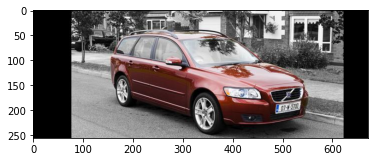

In [53]:
import cv2
img = cv2.imread(img_path%image_name, -1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [54]:
#     print(f'{item} = {annos_file[item]}')
# for item in annos_file:

'''
Annotation example:
    name = n02814533_10404
    box = [151. 407. 157. 829. 427. 829.]
    box_ori = [140. 275. 295. 469. 335. 500.]
    box_obj = [ 27. 200. 219. 441. 256. 672.]
    cropped_kp_list = [[  0.           0.        ]
    [  0.           0.        ]
    [  0.           0.        ]
    [  0.           0.        ]
    [  0.           0.        ]
    [  0.           0.        ]
    [ 48.23357636 254.21345823]
    [ 48.23357636 378.73558693]
    [  0.           0.        ]
    [  0.           0.        ]
    [ 88.79700593 232.89885963]
    [ 93.30405366 386.58833379]]
    visible = [2 2 2 2 2 2 1 1 2 2 1 1]
    occ_mask = None
    theta = -0.02453757441330697
    focal = 1
    elevation = -0.02975584770042751
    viewport = 3000
    width = 500
    azimuth = 3.243096872126876
    principal = [386.21454547 218.99966294]
    show more (open the raw output data in a text editor) ...

    principal = [386.21454547 218.99966294]
    distance = 6.384374659693176
    height = 335
    cad_index = 6
    bbox = [295.87205082 140.77676951 469.19328494 275.07803993]
''';

2.0


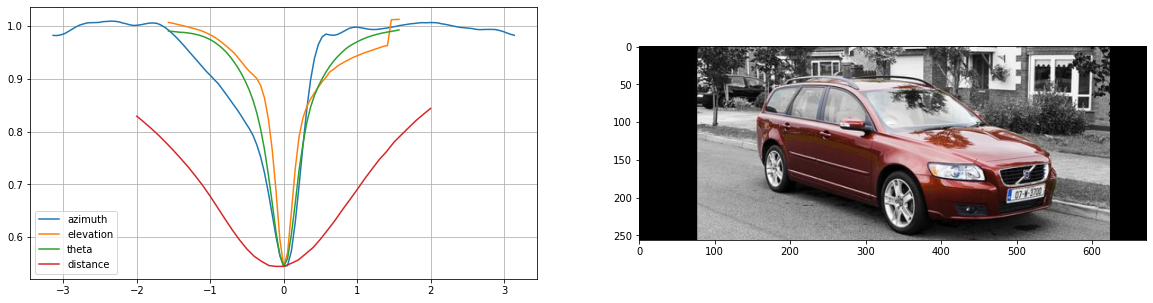

In [65]:
get = []
for azimuth_shift in azimuth_shifts:
    this_azum = (annos_file['azimuth'] + azimuth_shift + 2 * np.pi) % (2 * np.pi)
    this_elev = annos_file['elevation']
    C = camera_position_from_spherical_angles(distance_render[cate], this_elev, this_azum, degrees=False, device=device)
    theta = torch.from_numpy(annos_file['theta']).type(torch.float32).view(1)
    projected_map = inter_module(C, theta).squeeze()
    sim_ = torch.sum(projected_map * predicted_map, dim=0)
    get.append(1 - (torch.mean(sim_)).item())
    # if np.abs(azimuth_shift) < 1e-5:
    #     print(C, (torch.mean(sim_)).item())

azum_scan = np.array(get)

get = []
for elevation_shift in elevation_shifts:
    this_azum = annos_file['azimuth']
    this_elev = annos_file['elevation'] + elevation_shift
    C = camera_position_from_spherical_angles(distance_render[cate], this_elev, this_azum, degrees=False, device=device)
    theta = torch.from_numpy(annos_file['theta']).type(torch.float32).view(1)
    projected_map = inter_module(C, theta).squeeze()
    sim_ = torch.sum(projected_map * predicted_map, dim=0)
    get.append(1 - (torch.mean(sim_)).item())
    # if np.abs(elevation_shift) < 1e-5:
    #     print(C, (torch.mean(sim_)).item())
elev_scan = np.array(get)

get = []
for theta_shift in theta_shifts:
    this_azum = annos_file['azimuth']
    this_elev = annos_file['elevation']
    C = camera_position_from_spherical_angles(distance_render[cate], this_elev, this_azum, degrees=False, device=device)
    theta = torch.from_numpy(np.array(annos_file['theta'] + theta_shift)).type(torch.float32).view(1)
    projected_map = inter_module(C, theta).squeeze()
    sim_ = torch.sum(projected_map * predicted_map, dim=0)
    get.append(1 - (torch.mean(sim_)).item())
    # if np.abs(theta_shift) < 1e-5:
    #     print(C, (torch.mean(sim_)).item())
theta_scan = np.array(get)

get = []
for distance_shift in distance_shifts:
    this_azum = annos_file['azimuth']
    this_elev = annos_file['elevation']
    C = camera_position_from_spherical_angles(distance_render[cate] + distance_shift, this_elev, this_azum, degrees=False,
                                                device=device)
    theta = torch.from_numpy(np.array(annos_file['theta'])).type(torch.float32).view(1)
    projected_map = inter_module(C, theta).squeeze()
    sim_ = torch.sum(projected_map * predicted_map, dim=0)
    get.append(1 - (torch.mean(sim_)).item())
    # if np.abs(theta_shift) < 1e-5:
    #     print(C, (torch.mean(sim_)).item())
distance_scan = np.array(get)

this_dist = distance_shifts[np.argmax(distance_scan)]
print(this_dist)

values_ = [azimuth_shifts, elevation_shifts, theta_shifts, distance_shifts]
scans_ = [azum_scan, elev_scan, theta_scan, distance_scan]

colors_ = ['b', 'r', 'g']
fig, ax = plt.subplots(1,2, figsize=(20,5))
for idx in range(len(values_)):
    ax[0].plot(values_[idx], scans_[idx])

ax[0].grid(True)
ax[0].legend(['azimuth', 'elevation', 'theta', 'distance'])

ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].grid(False)